In [4]:
import json
import torch
from collections import defaultdict
from pathlib import Path

def build_flat_catalog(json_path: str, output_path: str):
    """
    Read a JSON catalog of lensing systems and write out a "flat" binary file
    with pre-stacked tensors for:
     - precomputed quantities (one row per system)
     - each mass-component type (rows of [sys_idx, *params]
     - each source-model type (rows of [sys_idx, *params])
    Also emits a small `param_map` per component/source type to decode columns.

    Args:
        json_path: path to the input JSON file (dict with key "SL_systems")
        output_path: path where to save the flat catalog (.pt)
    """
    # Load JSON
    with open(json_path, 'r') as f:
        catalog = json.load(f)
    systems = catalog.get("SL_systems", [])

    # Containers
    
    #For this one, differently form the following ones, there are not multiple tipes: we do not need default dict.
    #Also, here one row corresponds to one index, but for uniformity with following structures we write it like this.
    precomp_rows = {'sys_idxs': [], 'param_rows': []}
    
    #default dict: mass_data["type"] does not exist beforehand, but this way it gets created authomatically when called
    mass_data = defaultdict(lambda: {'sys_idxs': [], 'param_rows': []})
    
    
    #This way we are able to deal eventually with multiple sources
    source_data = defaultdict(lambda: {'sys_idxs': [], 'param_rows': []})

    # Define param order maps
    
    
    precomp_map = ['D_l', 'D_s', 'D_ls', 'Theta_E']
    
#NOTE: These should be externalized.
    mass_param_map = {
        'SIS': ['pos_x','pos_y','redshift','vel_disp'],
        'NFW': ['pos_x', 'pos_y','mass_max','r_max_kpc','redshift'],
        'ExternalPotential': ['shear_x','shear_y','shear_strength','shear_angle_arcsec'],
        'PEMD': ['pos_x', 'pos_y', 'redshift', 'vel_disp', 'slope', 'orient', 'q']

    }
    
    
    
    source_param_map = {
        'Gaussian_blob': ['I','position_rad_x', 'position_rad_y' ,'orient_rad','q','std_kpc','redshift'],
        # add other source types here
    }

    # Loop systems
    for sys in systems:
        i = sys['system_index']
        # precomputed
        pre = sys['precomputed']
        precomp_rows["sys_idxs"].append(i)
        
        row=[]
        for precomp_quant in precomp_map:
            row.append(pre[precomp_quant])
        precomp_rows["param_rows"].append(row)

        

         # mass components
        for mc in sys['lens_model'].get('mass_components', []):
            mtype  = mc['type']
            params = mc['params']

            # 1) pull out all non-position params in order
            nonpos = []
            for key in mass_param_map[mtype]:
                if key not in ('pos_x', 'pos_y', 'shear_x', 'shear_y'):
                    nonpos.append(params[key][0] if isinstance(params[key], (list, tuple)) and len(params[key]) == 1 else params[key])



            # 2) build your final row as [pos_x, pos_y, *nonpos]
            # check if the key pos exists in the params dictionary
            if 'pos' in params:
                row = [params['pos'][0], params['pos'][1], *nonpos]

            elif 'shear_center' in params:
                row = [params['shear_center'][0], params['shear_center'][1], *nonpos]
            # store it
            mass_data[mtype]['sys_idxs'].append(i)
            mass_data[mtype]['param_rows'].append(row)

        # source models
        sm = sys['source_model']
        source_type = sm['type']
        params = sm['params']
       
            
        nonpos = []
        for key in source_param_map[source_type]:
            if key not in ('position_rad_x', 'position_rad_y'):
                nonpos.append(params[key][0] if isinstance(params[key], (list, tuple)) and len(params[key]) == 1 else params[key])

        # 2) build your final row as [pos_x, pos_y, *nonpos]
            
        row = [params['position_rad'][0], params['position_rad'][0], *nonpos]
            
        source_data[source_type]['sys_idxs'].append(i)
        source_data[source_type]['param_rows'].append(row)

    
    
    # Convert to tensors
    flat = {
        'precomputed': {},
        'mass_components': {},
        'source_models': {}
    }

    # Precomputed quantities — mirror the mass/source pattern
    pc_idxs = torch.tensor(precomp_rows['sys_idxs'], dtype=torch.long)
    pc_vals = torch.tensor(precomp_rows['param_rows'], dtype=torch.float32)
    flat['precomputed'] = {
        'sys_idx':   pc_idxs,
        'params':    pc_vals,
        'param_map': precomp_map
    }

    # Mass components
    for mtype, dat in mass_data.items():
        idxs = torch.tensor(dat['sys_idxs'], dtype=torch.long)
        rows = torch.tensor(dat['param_rows'], dtype=torch.float32)
        flat['mass_components'][mtype] = {
            'sys_idx':   idxs,
            'params':    rows,
            'param_map': mass_param_map[mtype]
        }

    # Source models
    for stype, dat in source_data.items():
        idxs = torch.tensor(dat['sys_idxs'], dtype=torch.long)
        rows = torch.tensor(dat['param_rows'], dtype=torch.float32)
        flat['source_models'][stype] = {
            'sys_idx':   idxs,
            'params':    rows,
            'param_map': source_param_map[stype]
        }

    # Save
    torch.save(flat, Path(output_path))
    print(f"Flat catalog written to {output_path}")




In [5]:

json_path2="../../catalogs/test4_pemd.json"
output_path2="../../catalogs/test4_pemd.pth"

build_flat_catalog(json_path2, output_path2)



Flat catalog written to ../../catalogs/test4_pemd.pth


In [15]:

# Cell 1: imports & load
import torch
import pandas as pd
import matplotlib.pyplot as plt

# adjust this path as needed
catalog_path = "../../catalogs/something_with_shear.pth"
flat = torch.load(catalog_path)


In [16]:
# Cell 2: build precomputed DataFrame
pre = flat['precomputed']
# params is a [N, K] tensor and param_map lists column names
params = pre['params'].numpy()
columns = pre['param_map']
df_pre = pd.DataFrame(params, columns=columns)
df_pre['sys_idx'] = pre['sys_idx'].numpy()



In [17]:
# Cell 3: build one DataFrame per mass‐component type
df_mass = {}
for mtype, dat in flat['mass_components'].items():
    cols = dat['param_map']
    arr  = dat['params'].numpy()
    df    = pd.DataFrame(arr, columns=cols)
    df['sys_idx'] = dat['sys_idx'].numpy()
    df_mass[mtype] = df


In [18]:
# Cell 4: build one DataFrame per source‐model type
df_src = {}
for stype, dat in flat['source_models'].items():
    cols = dat['param_map']
    arr  = dat['params'].numpy()
    df    = pd.DataFrame(arr, columns=cols)
    df['sys_idx'] = dat['sys_idx'].numpy()
    df_src[stype] = df


In [19]:
# Cell 5: quick look at the tables
print("Precomputed:")
display(df_pre.head())

print("Mass types:", list(df_mass.keys()))
for mtype, df in df_mass.items():
    print(f"\n{mtype}")
    display(df.head())

print("Source types:", list(df_src.keys()))
for stype, df in df_src.items():
    print(f"\n{stype}")
    display(df.head())


Precomputed:


,D_l,D_s,D_ls,Theta_E,sys_idx
0,1725.993042,1491.569580,749.155457,0.000010,0
1,1522.398926,1546.743530,967.987793,0.000011,1
2,1783.760376,1211.701416,482.794739,0.000004,2
3,1751.351562,1507.346802,702.932068,0.000009,3
4,1652.031982,1280.655884,280.772156,0.000005,4


Mass types: ['PEMD', 'ExternalPotential', 'NFW']

PEMD


,pos_x,pos_y,redshift,vel_disp,slope,orient,q,sys_idx
0,0.0,0.0,1.080299,386.123322,1.000590,1.426060,0.845345,0
1,0.0,0.0,0.706136,353.338928,0.938577,0.047169,0.877640,1
2,0.0,0.0,1.830726,275.745209,0.936613,1.080825,0.837146,2
3,0.0,0.0,1.175066,378.687347,0.977938,0.468363,0.807400,3
4,0.0,0.0,2.839020,391.334045,1.079194,2.895834,0.853780,4



ExternalPotential


,shear_x,shear_y,shear_strength,shear_angle_arcsec,sys_idx
0,0.0,0.0,0.055165,3.124254,0
1,0.0,0.0,0.038536,1.326891,1
2,0.0,0.0,0.071367,4.942794,2
3,0.0,0.0,0.000637,6.268994,3
4,0.0,0.0,0.040448,5.030596,4



NFW


,pos_x,pos_y,mass_max,r_max_kpc,redshift,sys_idx
0,-1.425843e-06,4.524517e-07,1.000000e+11,3.576866,1.080299,0
1,9.472093e-07,-6.397777e-06,1.000000e+11,10.148184,0.706136,1
2,1.012840e-05,-6.789826e-06,1.000000e+11,15.593445,2.839020,4
3,1.394118e-05,-1.440833e-05,1.000000e+11,6.765317,0.936808,6
4,8.764418e-06,1.171582e-05,1.000000e+11,2.481410,0.249630,7


Source types: ['Gaussian_blob']

Gaussian_blob


,I,position_rad_x,position_rad_y,orient_rad,q,std_kpc,redshift,sys_idx
0,-2.927999e-07,-2.927999e-07,1.0,0.0,0.8,0.8,3.836359,0
1,9.463927e-07,9.463927e-07,1.0,0.0,0.8,0.8,3.487938,1
2,-1.143620e-07,-1.143620e-07,1.0,0.0,0.8,0.8,5.927276,2
3,2.187581e-06,2.187581e-06,1.0,0.0,0.8,0.8,3.735499,3
4,1.962735e-07,1.962735e-07,1.0,0.0,0.8,0.8,5.342922,4


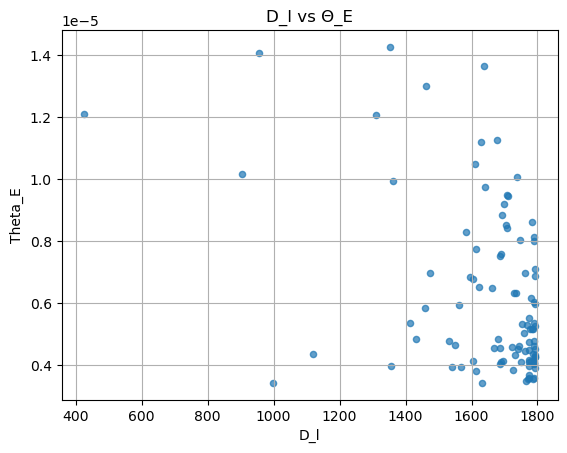

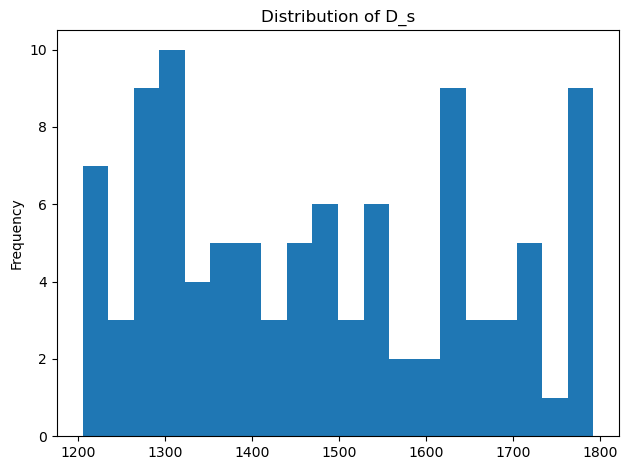

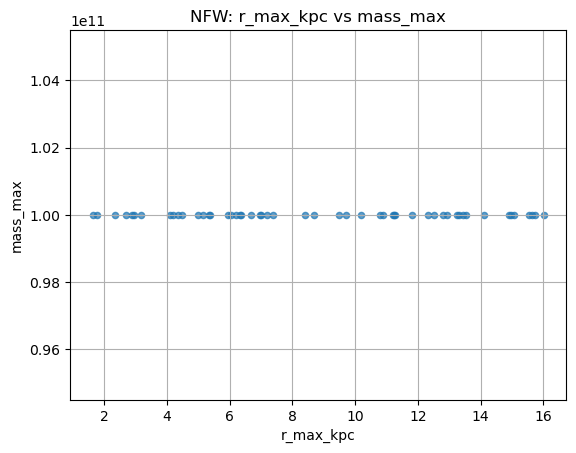

In [28]:
# Cell 6: simple plots
# 1) D_l vs Theta_E
ax = df_pre.plot.scatter(x='D_l', y='Theta_E', title='D_l vs Θ_E', alpha=0.7)
ax.grid(True)

# 2) histogram of D_s
plt.figure()
df_pre['D_s'].plot.hist(bins=20, title='Distribution of D_s')
plt.tight_layout()

# 3) if NFW present, r_max_kpc vs mass_max
if 'NFW' in df_mass:
    ax2 = df_mass['NFW'].plot.scatter(
        x='r_max_kpc', y='mass_max',
        title='NFW: r_max_kpc vs mass_max', alpha=0.7
    )
    ax2.grid(True)

plt.show()


In [3]:
import torch

def pprint_structure(obj, indent=0):
    pad = '  ' * indent
    if isinstance(obj, dict):
        for k, v in obj.items():
            print(f"{pad}{k!r}: {type(v).__name__}", end='')
            if hasattr(v, 'shape'):
                print(f"  shape={tuple(v.shape)}")
            else:
                print()
            pprint_structure(v, indent+1)
    elif isinstance(obj, (list, tuple)):
        for i, v in enumerate(obj):
            print(f"{pad}[{i}]: {type(v).__name__}", end='')
            if hasattr(v, 'shape'):
                print(f"  shape={tuple(v.shape)}")
            else:
                print()
            pprint_structure(v, indent+1)

# Usage:
catalog_path = "../../catalogs/small_example_catalog.pth"

flat = torch.load(catalog_path)
pprint_structure(flat)


'precomputed': dict
  'sys_idx': Tensor  shape=(100,)
  'params': Tensor  shape=(100, 4)
  'param_map': list
    [0]: str
    [1]: str
    [2]: str
    [3]: str
'mass_components': dict
  'PEMD': dict
    'sys_idx': Tensor  shape=(100,)
    'params': Tensor  shape=(100, 7)
    'param_map': list
      [0]: str
      [1]: str
      [2]: str
      [3]: str
      [4]: str
      [5]: str
      [6]: str
  'NFW': dict
    'sys_idx': Tensor  shape=(52,)
    'params': Tensor  shape=(52, 5)
    'param_map': list
      [0]: str
      [1]: str
      [2]: str
      [3]: str
      [4]: str
'source_models': dict
  'Gaussian_blob': dict
    'sys_idx': Tensor  shape=(100,)
    'params': Tensor  shape=(100, 7)
    'param_map': list
      [0]: str
      [1]: str
      [2]: str
      [3]: str
      [4]: str
      [5]: str
      [6]: str


In [2]:
from lensing_system_broadcasting import LensingSystem
import torch

catalog_path = "../../catalogs/test4_pemd.pth"
flat= torch.load(catalog_path)



masses_data = flat['mass_components']
for mtype, data in masses_data.items():
    # Convert to CUDA tensors
    masses_data[mtype]['params'] = data['params'].to(device='cuda:0')
    masses_data[mtype]['sys_idx'] = data['sys_idx'].to(device='cuda:0')


precomputed_data = flat['precomputed']

precomputed_data['params'] = precomputed_data['params'].to(device='cuda:0')
precomputed_data['sys_idx'] = precomputed_data['sys_idx'].to(device='cuda:0')

source_data = flat['source_models']
for mtype, data in source_data.items():
    # Convert to CUDA tensors
    source_data[mtype]['params'] = data['params'].to(device='cuda:0')
    source_data[mtype]['sys_idx'] = data['sys_idx'].to(device='cuda:0')


precomputed_data = flat['precomputed']

precomputed_data['params'] = precomputed_data['params'].to(device='cuda:0')
precomputed_data['sys_idx'] = precomputed_data['sys_idx'].to(device='cuda:0')


lensing_system = LensingSystem(
    num_samples=1,
    masses_data=masses_data,
    precomputed_data=precomputed_data,
    source_data=source_data,
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
)

cuda


lens_grid torch.Size([100, 100, 2])


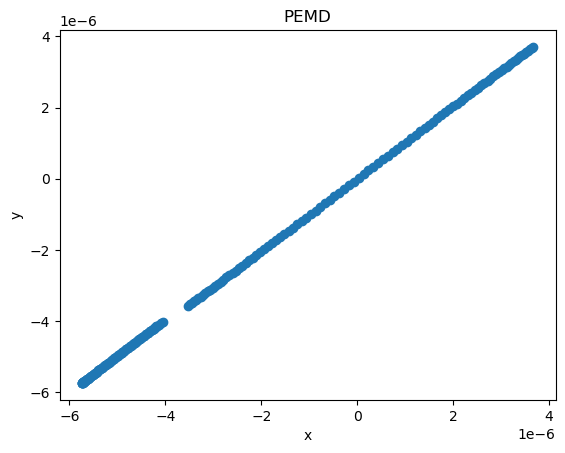

tensor([[[[-3.5226e-06, -4.0563e-06],
          [-3.4832e-06, -4.0994e-06],
          [-3.4426e-06, -4.1429e-06],
          ...,
          [ 3.5954e-06, -4.2437e-06],
          [ 3.6316e-06, -4.2043e-06],
          [ 3.6668e-06, -4.1652e-06]],

         [[-3.5658e-06, -4.0174e-06],
          [-3.5268e-06, -4.0611e-06],
          [-3.4866e-06, -4.1052e-06],
          ...,
          [ 3.6352e-06, -4.2101e-06],
          [ 3.6712e-06, -4.1702e-06],
          [ 3.7060e-06, -4.1306e-06]],

         [[-3.6096e-06, -3.9772e-06],
          [-3.5710e-06, -4.0214e-06],
          [-3.5311e-06, -4.0661e-06],
          ...,
          [ 3.6757e-06, -4.1753e-06],
          [ 3.7112e-06, -4.1348e-06],
          [ 3.7456e-06, -4.0947e-06]],

         ...,

         [[-3.7456e-06,  4.0947e-06],
          [-3.7112e-06,  4.1348e-06],
          [-3.6757e-06,  4.1753e-06],
          ...,
          [ 3.5311e-06,  4.0661e-06],
          [ 3.5710e-06,  4.0214e-06],
          [ 3.6096e-06,  3.9772e-06]],

     

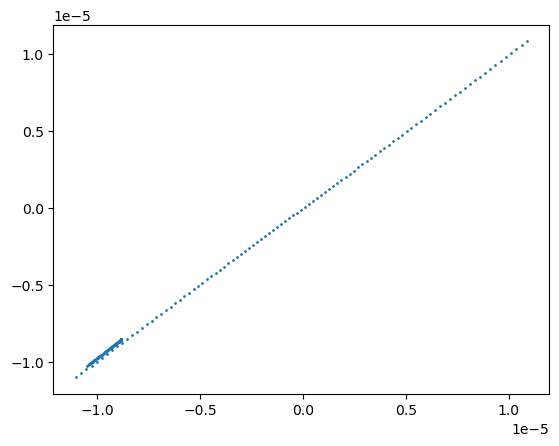

In [3]:
from shared_utils import _grid_lens
my_grid= _grid_lens(6, 100, device="cuda")

images, source_grid=lensing_system.forward(my_grid)


In [4]:
print(source_grid.shape)

torch.Size([1, 100, 100, 2])


torch.Size([100, 100, 2])
source grid is complex: False
Shape of tensor_source_grid2: torch.Size([100, 100, 2])
Shape of my_source_grid: torch.Size([100, 100, 2])
Are the two grids approximately equal? True
Max difference: tensor(2.2737e-12, device='cuda:0')
Mean difference: tensor(2.9366e-13, device='cuda:0')


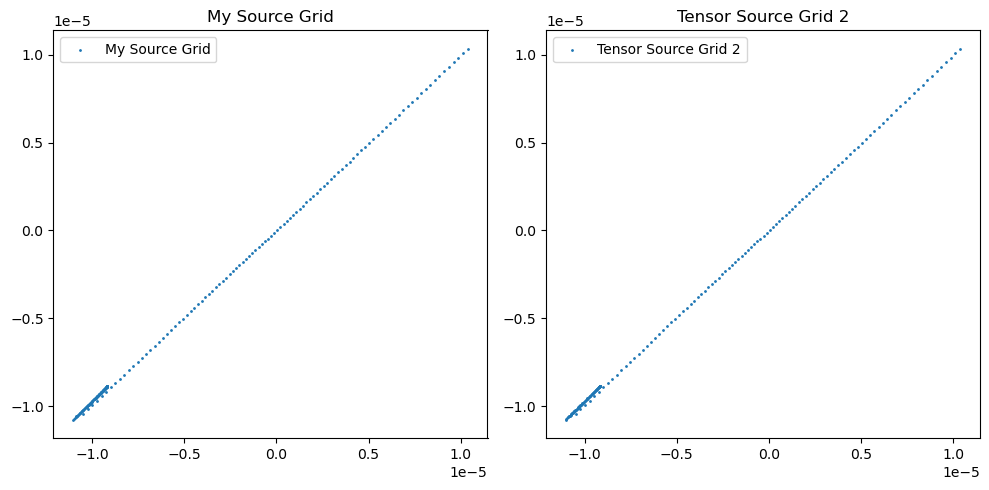

TypeError: Invalid shape (100,) for image data

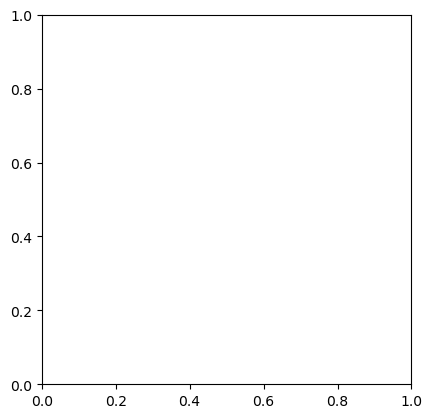

In [16]:
from lensing_system.sources import GaussianBlob


# Create a GaussianBlob source
source = GaussianBlob(
{
    "I": torch.tensor(1.0, device="cuda"),
    "position_rad": torch.tensor([
        8.816750512285077e-07,
        -6.083888355237159e-07
    ], device="cuda"),
    "orient_rad": torch.tensor(0.0, device="cuda"),
    "q": torch.tensor(0.8, device="cuda"),
    "std_kpc": torch.tensor(0.8, device="cuda"),
    "redshift": torch.tensor(4.796155058524947, device="cuda")
},
{
    "D_l": torch.tensor(1745.9939572172996, device="cuda"),
    "D_s": torch.tensor(1351.5695644910784, device="cuda"),
    "D_ls": torch.tensor(386.2062944671769, device="cuda"),
    "Theta_E": torch.tensor(5.881749693351248e-06, device="cuda")
}, device="cuda")

my_source_grid= source_grid[0]

print(my_source_grid.shape)
# check if the source grid is all real or also complex
print("source grid is complex:", torch.is_complex(my_source_grid))

#load the other source grid from the ../../notebooks/source_grid.npy
import numpy as np
my_source_grid2= np.load("../../notebooks/source_grid.npy")
tensor_source_grid2 = torch.tensor(my_source_grid2, device="cuda")
# Compare the two grids
print("Shape of tensor_source_grid2:", tensor_source_grid2.shape)
print("Shape of my_source_grid:", my_source_grid.shape)

# Check if the two grids are equal
are_equal = torch.allclose(my_source_grid, tensor_source_grid2, atol=1e-6)
print("Are the two grids approximately equal?", are_equal)

# Compute the difference
difference = my_source_grid - tensor_source_grid2
print("Max difference:", torch.max(torch.abs(difference)))
print("Mean difference:", torch.mean(torch.abs(difference)))

# Visualize the difference
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("My Source Grid")
plt.scatter(my_source_grid[:, 0].cpu(), my_source_grid[:, 1].cpu(), s=1, label="My Source Grid")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Tensor Source Grid 2")
plt.scatter(tensor_source_grid2[:, 0].cpu(), tensor_source_grid2[:, 1].cpu(), s=1, label="Tensor Source Grid 2")
plt.legend()

plt.tight_layout()
plt.show()

my_source_grid2=torch.tensor(my_source_grid2, device="cuda")
if my_source_grid2.dtype != torch.float32:
            my_source_grid2= my_source_grid2.to(dtype=torch.float32)
            #\  print("converting lens grid to dtype", lens_grid.dtype)

img= source.forward(my_source_grid2)

import matplotlib.pyplot as plt

plt.imshow(img[0].cpu().detach().numpy(), cmap='gray')

torch.Size([1, 100, 100, 2])
tensor([[[[-1.1022e-05, -1.0488e-05],
          [-1.0767e-05, -1.0445e-05],
          [-1.0514e-05, -1.0402e-05],
          ...,
          [ 1.0361e-05, -1.0301e-05],
          [ 1.0619e-05, -1.0340e-05],
          [ 1.0878e-05, -1.0379e-05]],

         [[-1.0979e-05, -1.0233e-05],
          [-1.0724e-05, -1.0189e-05],
          [-1.0470e-05, -1.0145e-05],
          ...,
          [ 1.0322e-05, -1.0040e-05],
          [ 1.0579e-05, -1.0080e-05],
          [ 1.0838e-05, -1.0120e-05]],

         [[-1.0935e-05, -9.9796e-06],
          [-1.0680e-05, -9.9353e-06],
          [-1.0426e-05, -9.8907e-06],
          ...,
          [ 1.0281e-05, -9.7815e-06],
          [ 1.0539e-05, -9.8220e-06],
          [ 1.0799e-05, -9.8621e-06]],

         ...,

         [[-1.0799e-05,  9.8621e-06],
          [-1.0539e-05,  9.8220e-06],
          [-1.0281e-05,  9.7815e-06],
          ...,
          [ 1.0426e-05,  9.8907e-06],
          [ 1.0680e-05,  9.9353e-06],
          [ 1.09

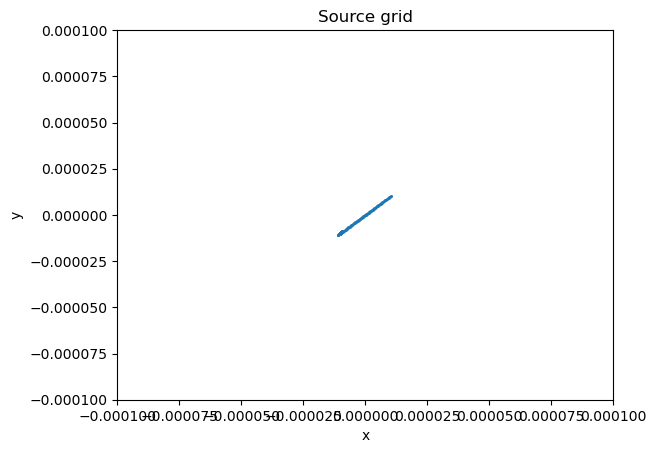

tensor([[[4.0365e-07, 4.0365e-07, 4.0365e-07,  ..., 4.0365e-07,
          4.0365e-07, 4.0365e-07],
         [4.0365e-07, 4.0365e-07, 4.0365e-07,  ..., 4.0365e-07,
          4.0365e-07, 4.0365e-07],
         [4.0365e-07, 4.0365e-07, 4.0365e-07,  ..., 4.0365e-07,
          4.0365e-07, 4.0365e-07],
         ...,
         [4.0367e-07, 4.0367e-07, 4.0367e-07,  ..., 4.0367e-07,
          4.0367e-07, 4.0367e-07],
         [4.0367e-07, 4.0367e-07, 4.0367e-07,  ..., 4.0367e-07,
          4.0367e-07, 4.0367e-07],
         [4.0367e-07, 4.0367e-07, 4.0367e-07,  ..., 4.0367e-07,
          4.0367e-07, 4.0367e-07]]], device='cuda:0')


In [3]:
print(source_grid.shape)
print(source_grid)

# scatter plot the first sorce grid
import matplotlib.pyplot as plt
plt.scatter(source_grid[0, :, 0].cpu(), source_grid[0, :, 1].cpu(), s=1)
plt.title("Source grid")
plt.xlabel("x")
plt.ylabel("y")

zoom=1e4

lim=1/zoom

plt.xlim(-lim, lim)
plt.ylim(-lim, lim)
plt.show()

print(images)

torch.Size([1, 100, 100])


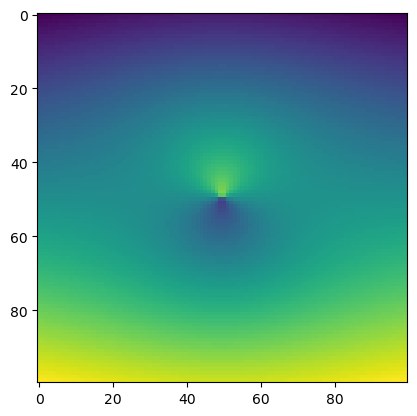

In [4]:
print(images.shape)

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
for i in range(1):
    first_image = images[i]

    # Convert the first image to a numpy array
    first_image_np = first_image.cpu().numpy()

    plt.imshow(first_image_np, cmap='viridis')
    plt.show()


In [2]:

# Cell 1: imports & load
import torch

# adjust this path as needed
catalog_path = "../../catalogs/small_example_catalog.pth"
flat = torch.load(catalog_path)

In [3]:
Pemd_tensor_init=flat["mass_components"]["PEMD"]
print(Pemd_tensor_init.keys())



dict_keys(['sys_idx', 'params', 'param_map'])


In [4]:
Pemd_tensor_init=flat["mass_components"]["PEMD"]['params']

precomputed_tensor_init=flat["precomputed"]
print(precomputed_tensor_init["params"].device)
precomputed_tensor_init["params"] = precomputed_tensor_init["params"].to("cuda")

print(precomputed_tensor_init.keys())


cpu
dict_keys(['sys_idx', 'params', 'param_map'])


In [5]:
my_pemd=PEMD(Pemd_tensor_init.to("cuda:0"),
            precomputed_tensor_init)

In [1]:
Nfw_tensor_init=flat["mass_components"]["NFW"]['params']

#now the initialization of the precomputed quantities is more tricky
Nfw_indexes=flat["mass_components"]["NFW"]['sys_idx']



print(torch.max(Nfw_indexes))

print(len(Nfw_tensor_init))



#now we slice up the nfw tensor to get the pre
precomputed_nfw_params=flat["precomputed"]["params"][Nfw_indexes]
precomputed_nfw_map=flat["precomputed"]["param_map"]

precomputed_init_nfw={
    "params":precomputed_nfw_params.to("cuda:0"),
    "param_map":precomputed_nfw_map
}
print(Nfw_tensor_init.type())

NameError: name 'flat' is not defined

In [9]:
device = "cuda:0"
dtype  = torch.float32

# assume `Nfw_tensor_init` is already your [B,7] tensor including the D_l, D_s, D_ls columns
#param_tensor = Nfw_tensor_init.to(device=device, dtype=dtype)

my_nfw = NFW(Nfw_tensor_init.to(device=device, dtype=dtype),
             precomputed_init_nfw,
             device=device, dtype=dtype)


In [4]:
from lensing_system_broadcasting import LensModel
# Cell 1: imports & load
import torch

# adjust this path as needed
catalog_path = "../../catalogs/SIS_10e11_sub_small_test.pth"
flat = torch.load(catalog_path)


In [5]:
masses_data = flat['mass_components']
for mtype, data in masses_data.items():
    # Convert to CUDA tensors
    masses_data[mtype]['params'] = data['params'].to(device='cuda:0')
    masses_data[mtype]['sys_idx'] = data['sys_idx'].to(device='cuda:0')


precomputed_data = flat['precomputed']

precomputed_data['params'] = precomputed_data['params'].to(device='cuda:0')
precomputed_data['sys_idx'] = precomputed_data['sys_idx'].to(device='cuda:0')

my_lens_model = LensModel(
    number_of_systems=100,
    masses_data=masses_data,
    precomputed=precomputed_data,
)

# Lets try a forward pass

In [6]:
from shared_utils import _grid_lens

my_grid= _grid_lens(3, 100, device="cuda:0")

In [8]:
deflectedPoints=my_lens_model(my_grid)

lens_grid torch.Size([100, 100, 2])


In [9]:
print(deflectedPoints.shape)

torch.Size([100, 100, 100, 2])


In [10]:
first_field=deflectedPoints[5]


print(first_field)

tensor([[[-2.3960e-06, -2.4727e-06],
         [-2.2985e-06, -2.4226e-06],
         [-2.2025e-06, -2.3720e-06],
         ...,
         [ 2.1432e-06, -2.3149e-06],
         [ 2.2410e-06, -2.3638e-06],
         [ 2.3403e-06, -2.4122e-06]],

        [[-2.3459e-06, -2.3783e-06],
         [-2.2478e-06, -2.3277e-06],
         [-2.1513e-06, -2.2765e-06],
         ...,
         [ 2.0938e-06, -2.2177e-06],
         [ 2.1921e-06, -2.2671e-06],
         [ 2.2920e-06, -2.3159e-06]],

        [[-2.2954e-06, -2.2853e-06],
         [-2.1967e-06, -2.2343e-06],
         [-2.0996e-06, -2.1826e-06],
         ...,
         [ 2.0440e-06, -2.1220e-06],
         [ 2.1428e-06, -2.1719e-06],
         [ 2.2432e-06, -2.2211e-06]],

        ...,

        [[-2.2432e-06,  2.2211e-06],
         [-2.1428e-06,  2.1719e-06],
         [-2.0440e-06,  2.1220e-06],
         ...,
         [ 2.0996e-06,  2.1826e-06],
         [ 2.1967e-06,  2.2343e-06],
         [ 2.2954e-06,  2.2853e-06]],

        [[-2.2920e-06,  2.3159e-06

In [11]:
from lensing_system_broadcasting import SourceModel
# Cell 1: imports & load
import torch

# adjust this path as needed
catalog_path = "../../catalogs/SIS_10e11_sub_small_test.pth"
flat = torch.load(catalog_path)
print(flat.keys())

dict_keys(['precomputed', 'mass_components', 'source_models'])


In [14]:
source_data = flat['source_models']
for mtype, data in source_data.items():
    # Convert to CUDA tensors
    source_data[mtype]['params'] = data['params'].to(device='cuda:0')
    source_data[mtype]['sys_idx'] = data['sys_idx'].to(device='cuda:0')


precomputed_data = flat['precomputed']

precomputed_data['params'] = precomputed_data['params'].to(device='cuda:0')
precomputed_data['sys_idx'] = precomputed_data['sys_idx'].to(device='cuda:0')

my_source_model = SourceModel(
    source_data=source_data,
    precomputed=precomputed_data,
)

In [16]:
# now lets try calling the forward pass

source_eval=my_source_model(deflectedPoints)


In [17]:
print(source_eval.shape)

torch.Size([100, 100, 100])
